In [1]:
import numpy as np
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mne.decoding import CSP
from scipy.fftpack import fft
from scipy.signal import butter, lfilter
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import pywt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=1, highcut=50, fs=100, order=4):
    if lowcut <= 0 or highcut >= fs / 2:
        raise ValueError(f"Invalid filter cutoffs: lowcut must be > 0 and highcut < fs/2 (fs={fs})")
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return lfilter(b, a, data, axis=0)

# Wavelet Denoising
def wavelet_denoising(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    threshold = np.sqrt(2 * np.log(len(signal)))
    coeffs_thresholded = [pywt.threshold(c, threshold, mode='soft') for c in coeffs]
    reconstructed_signal = pywt.waverec(coeffs_thresholded, wavelet)

    if len(reconstructed_signal) > len(signal):
        return reconstructed_signal[:len(signal)]
    elif len(reconstructed_signal) < len(signal):
        return np.pad(reconstructed_signal, (0, len(signal) - len(reconstructed_signal)), 'constant')
    return reconstructed_signal

# Data Loading and Preprocessing
file_list = ['BCICIV_calib_ds1a.mat','BCICIV_calib_ds1b.mat','BCICIV_calib_ds1c.mat','BCICIV_calib_ds1e.mat','BCICIV_calib_ds1d.mat','BCICIV_calib_ds1f.mat','BCICIV_calib_ds1m.mat',
             'BCICIV_calib_ds1h.mat','BCICIV_calib_ds1i.mat','BCICIV_calib_ds1j.mat','BCICIV_calib_ds1l.mat','BCICIV_calib_ds1k.mat','BCICIV_calib_ds1m.mat','BCICIV_calib_ds1f.mat']

epoch_start, epoch_end, sampling_rate = -0.5, 1.5, 100
all_trials, all_labels = [], []

for file_path in file_list:
    mat_data = sio.loadmat(file_path)
    eeg_data = mat_data['cnt']
    event_markers = mat_data['mrk']['pos'][0, 0].flatten()
    event_labels = mat_data['mrk']['y'][0, 0].flatten()
    n_samples, n_channels = eeg_data.shape

    # Apply bandpass filtering
    eeg_data = bandpass_filter(eeg_data, lowcut=1, highcut=49, fs=sampling_rate)

    # Apply wavelet denoising to each channel
    for channel in range(n_channels):
        eeg_data[:, channel] = wavelet_denoising(eeg_data[:, channel])
        
    start_samples = int(epoch_start * sampling_rate)
    end_samples = int(epoch_end * sampling_rate)

    for idx, event_pos in enumerate(event_markers):
        start_idx, end_idx = event_pos + start_samples, event_pos + end_samples
        if start_idx < 0 or end_idx > n_samples:
            continue

        epoch_data = eeg_data[start_idx:end_idx, :]
        all_trials.append(epoch_data)
        all_labels.append(event_labels[idx])

final_data = np.array(all_trials)
final_labels = np.array(all_labels)

# Convert labels from -1 and 1 to 0 and 1
final_labels = np.where(final_labels == -1, 0, final_labels)

# FBCSP Implementation
n_bands = 9  # Define the number of frequency bands
freq_bands = [(4, 8), (8, 12), (12, 16), (16, 20), (20, 24), (24, 28), (28, 32), (32, 36), (36, 40)]
filtered_epochs = []
for band in freq_bands:
    filtered_data = np.array([bandpass_filter(trial, band[0], band[1], fs=sampling_rate) for trial in final_data])
    filtered_epochs.append(filtered_data)
# Convert to numpy array
filtered_epochs = np.array(filtered_epochs)  # Shape (n_bands, n_trials, n_samples, n_channels)

# Apply CSP with more components
csp_features = []
for band_data in filtered_epochs:
    csp = CSP(n_components=8, reg='ledoit_wolf', log=True, norm_trace=False)  # Increased n_components
    transformed_data = csp.fit_transform(band_data.transpose(0, 2, 1), final_labels)
    csp_features.append(transformed_data)
# Concatenate features from all bands
csp_features = np.concatenate(csp_features, axis=1)

# Wavelet Transform Feature Extraction
wavelet_features = []
for trial in final_data:
    coeffs = pywt.wavedec(trial, 'db4', level=4, axis=0)
    coeffs_flat = np.hstack([coeff.flatten() for coeff in coeffs])
    wavelet_features.append(coeffs_flat)
wavelet_features = np.array(wavelet_features)

# FFT Feature Extraction
fft_features = []
for trial in final_data:
    fft_coeffs = np.abs(fft(trial, axis=0))
    fft_features.append(fft_coeffs.flatten())
fft_features = np.array(fft_features)

# Train/Test split for traditional model
X_train, X_test, y_train, y_test = train_test_split(csp_features, final_labels, test_size=0.2, random_state=42)
X_train_wavelet, X_test_wavelet, _, _ = train_test_split(wavelet_features, final_labels, test_size=0.2, random_state=42)
X_train_fft, X_test_fft, _, _ = train_test_split(fft_features, final_labels, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\juvvi\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\juvvi\AppData\Roaming\Python\Python311\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


Computing rank from data with rank=None
    Using tolerance 5.9e+03 (2.2e-16 eps * 59 dim * 4.5e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 5.6e+03 (2.2e-16 eps * 59 dim * 4.3e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3e+03 (2.2e-16 eps * 59 dim * 2.3e+17  max singular value)
    Estimated rank (mag): 59
    MAG: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating covariance using LEDOIT_WOLF
Done.
Computing rank from data with rank=None
    Using tolerance 3.1e+03 (2.2e-16 eps * 59 dim * 2.3e+17  max singular val

Epoch 1/20, Loss: 0.0193504633781101
Epoch 2/20, Loss: 0.016379333473742007
Epoch 3/20, Loss: 0.015066481261913265
Epoch 4/20, Loss: 0.013555450404861143
Epoch 5/20, Loss: 0.011424886115959713
Epoch 6/20, Loss: 0.00979409907013178
Epoch 7/20, Loss: 0.008746298901470644
Epoch 8/20, Loss: 0.007258205371908843
Epoch 9/20, Loss: 0.00500035669288731
Epoch 10/20, Loss: 0.004369892095149095
Epoch 11/20, Loss: 0.0026870862863558743
Epoch 12/20, Loss: 0.0020423345824903145
Epoch 13/20, Loss: 0.0014848962752564278
Epoch 14/20, Loss: 0.0010226137978731587
Epoch 15/20, Loss: 0.0013618838080479432
Epoch 16/20, Loss: 0.0015262458001546163
Epoch 17/20, Loss: 0.0002990016956573527
Epoch 18/20, Loss: 0.00011841753972216143
Epoch 19/20, Loss: 7.84543535051593e-05
Epoch 20/20, Loss: 3.444982309831955e-05
Accuracy with DeepConvNet: 0.95
Classification Report for DeepConvNet:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       295
           1       0.94

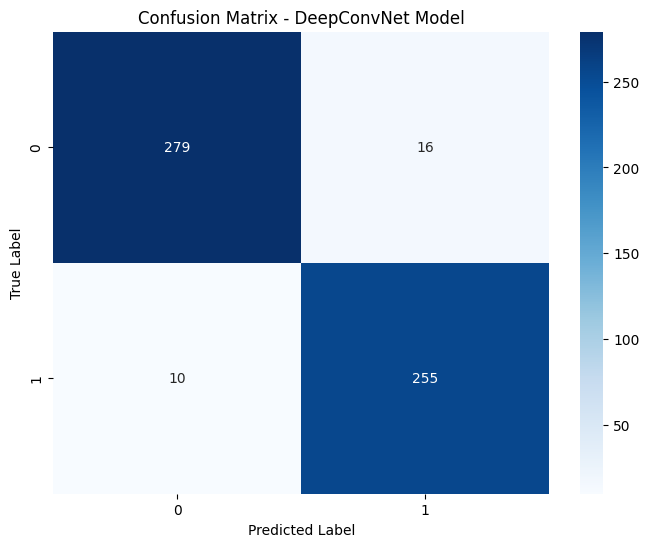

In [2]:
# DeepConvNet model
class DeepConvNet(nn.Module):
    def __init__(self, input_shape, n_classes):
        super(DeepConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 25, (1, 10), padding=0)
        self.conv2 = nn.Conv2d(25, 50, (1,10), padding=0)
        self.conv3 = nn.Conv2d(50, 100, (1, 10), padding=0)
        self.fc1 = nn.Linear(100* (input_shape[1] - 27), 64)
        self.fc2 = nn.Linear(64, n_classes)
 
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
# Train the DeepConvNet 
# ...
# Prepare data for PyTorch model
X_train_torch = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).unsqueeze(1) # Add channel dimension
y_train_torch = torch.tensor(y_train, dtype=torch.long)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1).unsqueeze(1)
y_test_torch = torch.tensor(y_test, dtype=torch.long)

# Initialize DeepConvNet model

# Model Initialization
input_shape = X_train_torch.shape[2:]  # Shape without batch dimension
n_classes = 2
deep_model = DeepConvNet(input_shape, n_classes)
optimizer = optim.Adam(deep_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
n_epochs = 20
batch_size = 32

def train_model(model, optimizer, criterion, X_train, y_train, n_epochs=20, batch_size=32):
    model.train()
    for epoch in range(n_epochs):
        permutation = torch.randperm(X_train.size(0))
        epoch_loss = 0
        
        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_X, batch_y = X_train[indices], y_train[indices]

            optimizer.zero_grad()

            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss / X_train.size(0)}")

train_model(deep_model, optimizer, criterion, X_train_torch, y_train_torch, n_epochs, batch_size)

# Evaluation on test set
deep_model.eval()
with torch.no_grad():
    outputs = deep_model(X_test_torch)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_torch).sum().item() / y_test_torch.size(0)
    print(f"Accuracy with DeepConvNet: {accuracy:.2f}")

# Classification Report
print("Classification Report for DeepConvNet:")
print(classification_report(y_test, predicted.numpy()))

# Confusion matrix for DeepConvNet
deep_conf_matrix = confusion_matrix(y_test, predicted.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(deep_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - DeepConvNet Model')
plt.show()


In [3]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Function

class ReverseLayerF(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha
        return output, None

class Conv2dWithConstraint(nn.Conv2d):
    def __init__(self, *args, doWeightNorm=True, max_norm=1, **kwargs):
        self.max_norm = max_norm
        self.doWeightNorm = doWeightNorm
        super(Conv2dWithConstraint, self).__init__(*args, **kwargs)
    
    def forward(self, x):
        if self.doWeightNorm: 
            self.weight.data = torch.renorm(
                self.weight.data, p=2, dim=0, maxnorm=self.max_norm
            )
        return super(Conv2dWithConstraint, self).forward(x)
    
    def __call__(self, *input, **kwargs):
        return super()._call_impl(*input, **kwargs)

class Conv1dWithConstraint(nn.Conv1d):
    def __init__(self, *args, doWeightNorm=True, max_norm=1, **kwargs):
        self.max_norm = max_norm
        self.doWeightNorm = doWeightNorm
        super(Conv1dWithConstraint, self).__init__(*args, **kwargs)
        if self.bias:
            self.bias.data.fill_(0.0)
            
    def forward(self, x):
        if self.doWeightNorm: 
            self.weight.data = torch.renorm(
                self.weight.data, p=2, dim=0, maxnorm=self.max_norm
            )
        return super(Conv1dWithConstraint, self).forward(x)

class LinearWithConstraint(nn.Linear):
    def __init__(self, *args, doWeightNorm=True, max_norm=1, **kwargs):
        self.max_norm = max_norm
        self.doWeightNorm = doWeightNorm
        super(LinearWithConstraint, self).__init__(*args, **kwargs)
        if self.bias is not None:
            self.bias.data.fill_(0.0)

    def forward(self, x):
        if self.doWeightNorm: 
            self.weight.data = torch.renorm(
                self.weight.data, p=2, dim=0, maxnorm=self.max_norm
            )
        return super(LinearWithConstraint, self).forward(x)

C:\Users\juvvi\AppData\Roaming\Python\Python311\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 1/20, Loss: 0.5540
Epoch 2/20, Loss: 0.4086
Epoch 3/20, Loss: 0.2135
Epoch 4/20, Loss: 0.3171
Epoch 5/20, Loss: 0.3504
Epoch 6/20, Loss: 0.2813
Epoch 7/20, Loss: 0.1797
Epoch 8/20, Loss: 0.2463
Epoch 9/20, Loss: 0.2174
Epoch 10/20, Loss: 0.1583
Epoch 11/20, Loss: 0.2242
Epoch 12/20, Loss: 0.2278
Epoch 13/20, Loss: 0.3342
Epoch 14/20, Loss: 0.1136
Epoch 15/20, Loss: 0.1501
Epoch 16/20, Loss: 0.1715
Epoch 17/20, Loss: 0.1497
Epoch 18/20, Loss: 0.1822
Epoch 19/20, Loss: 0.1907
Epoch 20/20, Loss: 0.1146
Test Accuracy: 0.89
Classification Report for TCN:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       295
           1       0.89      0.88      0.89       265

    accuracy                           0.89       560
   macro avg       0.89      0.89      0.89       560
weighted avg       0.89      0.89      0.89       560



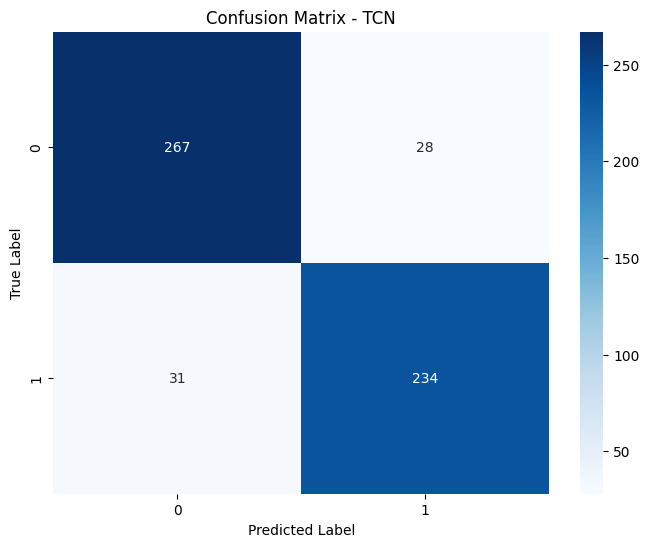

In [ ]:
# TCN
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define TCN
def Conv1dWithConstraint(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True, max_norm=1):
    conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, dilation, bias=bias)
    torch.nn.utils.weight_norm(conv)
    return conv

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = Conv1dWithConstraint(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = Conv1dWithConstraint(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1, self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        for i in range(len(num_channels)):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size, padding=(kernel_size-1) * dilation_size, dropout=dropout))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Train the TCN model
class TCNClassifier(nn.Module):
    def __init__(self, input_size, num_channels, num_classes):
        super(TCNClassifier, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels)
        self.fc = nn.Linear(num_channels[-1], num_classes)

    def forward(self, x):
        out = self.tcn(x.transpose(1, 2))
        out = self.fc(out[:, :, -1])  # Use the last time step
        return out

model = TCNClassifier(input_size=X_train.shape[1], num_channels=[32, 64, 128], num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch.unsqueeze(1))
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

# Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch.unsqueeze(1))
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds)
        all_labels.append(y_batch)

# Concatenate all predictions
y_pred = torch.cat(all_preds)
y_true = torch.cat(all_labels)

# Accuracy
accuracy = (y_pred == y_true).float().mean().item()
print(f"Test Accuracy: {accuracy:.2f}")

# Classification Report
print("Classification Report for TCN:")
print(classification_report(y_true.numpy(), y_pred.numpy()))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_true.numpy(), y_pred.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - TCN')
plt.show()

C:\Users\juvvi\AppData\Roaming\Python\Python311\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 1/20, Loss: 0.019106845371425152
Epoch 2/20, Loss: 0.015031304503125804
Epoch 3/20, Loss: 0.012891470813857657
Epoch 4/20, Loss: 0.010344778659886547
Epoch 5/20, Loss: 0.008686724707617291
Epoch 6/20, Loss: 0.00746813641661512
Epoch 7/20, Loss: 0.006360953174797552
Epoch 8/20, Loss: 0.004751333875382053
Epoch 9/20, Loss: 0.0036420519139418114
Epoch 10/20, Loss: 0.0029199065802718647
Epoch 11/20, Loss: 0.0016627246094036048
Epoch 12/20, Loss: 0.0017501889472311763
Epoch 13/20, Loss: 0.002189409320791518
Epoch 14/20, Loss: 0.0009707897630245757
Epoch 15/20, Loss: 0.0007852001529369902
Epoch 16/20, Loss: 0.00017498934435674788
Epoch 17/20, Loss: 5.887276684656432e-05
Epoch 18/20, Loss: 2.6592883900125993e-05
Epoch 19/20, Loss: 2.1432947450453607e-05
Epoch 20/20, Loss: 1.4893407751515042e-05
Accuracy with Combined Model: 0.95
Classification Report for DeepConvNet:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       295
           1

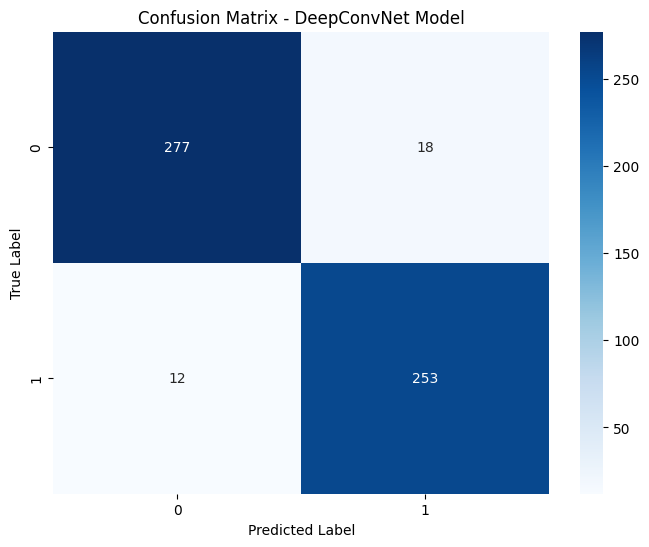

In [ ]:
# Hybrid Model
import torch
import torch.nn as nn
import torch.optim as optim

class CombinedModel(nn.Module):
    def __init__(self, deepconvnet, tempconvnet, deep_input_shape, num_classes):
        super(CombinedModel, self).__init__()
        
        self.deepconvnet = deepconvnet
        self.tempconvnet = tempconvnet
        
        deepconv_output_dim = 64  # Output of DeepConvNet's fc1 layer
        tempconv_output_dim = 128  # Output of TemporalConvNet
        
        self.fc_combined = nn.Linear(deepconv_output_dim + tempconv_output_dim, num_classes)
        
    def forward(self, x):
        deep_features = self.deepconvnet.forward_features(x)  # Extract features from DeepConvNet
        temp_features = self.tempconvnet.forward_features(x)  # Extract features from TempConvNet
        
        combined_features = torch.cat((deep_features, temp_features), dim=1)
        output = self.fc_combined(combined_features)
        return output

# Modify DeepConvNet and TCNClassifier to expose feature extraction layers
class DeepConvNetModified(DeepConvNet):
    def forward_features(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        return x  # Output features

class TCNClassifierModified(TCNClassifier):
    def forward_features(self, x):
        x = x.squeeze(2)  # Remove the extra dimension if it exists ([batch, 1, 1, features] -> [batch, 1, features])
        x = x.transpose(1, 2)
        x = self.tcn(x)   # Pass it through the temporal conv net
        x = x[:, :, -1]  # Use last time step output
        return x

# Initialize and Train the Combined Model
deepconv_model = DeepConvNetModified(input_shape, n_classes)
tempconv_model = TCNClassifierModified(input_size=X_train.shape[1], num_channels=[32, 64, 128], num_classes=2)

combined_model = CombinedModel(deepconv_model, tempconv_model, input_shape, n_classes)
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
n_epochs = 20
batch_size = 32
train_model(combined_model, optimizer, criterion, X_train_torch, y_train_torch, n_epochs, batch_size)

# Evaluation
combined_model.eval()
with torch.no_grad():
    outputs = combined_model(X_test_torch)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_torch).sum().item() / y_test_torch.size(0)
    print(f"Accuracy with Combined Model: {accuracy:.2f}")

# Classification Report
print("Classification Report for DeepConvNet:")
print(classification_report(y_test, predicted.numpy()))

# Confusion matrix for DeepConvNet
deep_conf_matrix = confusion_matrix(y_test, predicted.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(deep_conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - DeepConvNet Model')
plt.show()